In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import re

In [2]:
dataset_pth = '../data/dataset/dataset.json'

In [3]:
def read_json(path):
    with open(path, 'r') as file:
        return json.load(file)

In [4]:
dataset = pd.read_json(dataset_pth)

In [5]:
choosen_feat = ['username', 'is_name_social_political', 'desc',
               'tweets', 'n_tweet', 'quoted_tweets', 'n_tweet_use_hashtag',
               'ratio_tweets_use_hashtag', 'n_photo', 'n_video', 'buzzer']
dataset = dataset[choosen_feat]

In [6]:
dataset.head(2)

,username,is_name_social_political,desc,tweets,n_tweet,quoted_tweets,n_tweet_use_hashtag,ratio_tweets_use_hashtag,n_photo,n_video,buzzer
0,BasmallahP,0,akun baru lagi kesekian,[gasengaja negarawan nebarkebencian nuduhsemba...,134,[perbawadani tanyoana hasanba15701205 tangkapm...,112,0.835821,67.0,1.0,1
1,mohsach,0,ve far not saying far enough sedang berjuang t...,"[akhirnya liverpoolchampions ynwa, amin mujiba...",19,"[liverpool premier league champions, doa kabul...",3,0.157895,1.0,0.0,0


In [7]:
def text_cleaning(list_text):
    out = [re.sub(r'\b\d+\b', ' ', text) for text in list_text]
    return out

In [8]:
dataset['combine_tweet'] = dataset.tweets + dataset.quoted_tweets
dataset['clean_text'] = dataset.combine_tweet.apply(text_cleaning)

In [9]:
dataset['text_used'] = dataset.clean_text.apply(lambda x: " ".join(x))

In [10]:
dataset = dataset[dataset.tweets.str.len() != 0]

In [11]:
dataset.set_index(['username'], inplace=True)

## Modeling

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import SimpleImputer

In [13]:
X = dataset
y = dataset['buzzer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('combine_tweet', TfidfVectorizer(max_df=0.5), 'text_used'),
        ('user_desc', TfidfVectorizer(max_df=0.5), 'desc'),
        ('is_name', SimpleImputer(strategy='most_frequent'), ['is_name_social_political']),
        ('ratio', SimpleImputer(strategy='median'), ['ratio_tweets_use_hashtag']),
        ('numeric', StandardScaler(), ['n_tweet', 'n_photo', 'n_video'])
    ])

In [15]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=400))
    ]
)

In [16]:
def scoring(y_test, y_pred):
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"accuracy: {acc:.2f} | precision: {pre:.2f} | recall: {rec:.2f} | f score: {f1:.2f}")

In [17]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('combine_tweet',
                                                  TfidfVectorizer(max_df=0.5),
                                                  'text_used'),
                                                 ('user_desc',
                                                  TfidfVectorizer(max_df=0.5),
                                                  'desc'),
                                                 ('is_name',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['is_name_social_political']),
                                                 ('ratio',
                                                  SimpleImputer(strategy='median'),
                                                  ['ratio_tweets_use_hashtag']),
                                                 ('numeric', StandardScaler(),
                    

In [18]:
y_pred = pipe.predict(X_test)

In [19]:
# Evaluate
scoring(y_test, y_pred)

accuracy: 0.82 | precision: 0.73 | recall: 0.27 | f score: 0.39


<AxesSubplot:ylabel='buzzer'>

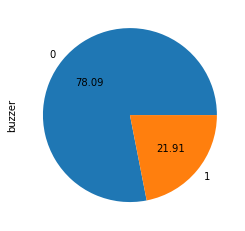

In [20]:
# Check imbalance dataset
y.value_counts().plot.pie(autopct='%.2f')

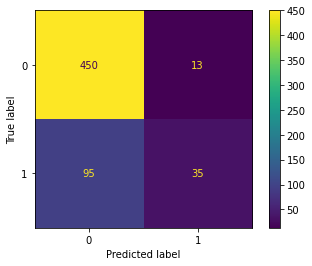

In [21]:
plot_confusion_matrix(pipe, X_test, y_test)

## ONLY Tweets text features

In [22]:
tfidf = TfidfVectorizer(max_df=0.5)
data_tfidf = tfidf.fit_transform(dataset.text_used)

X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(data_tfidf, dataset.buzzer, test_size=0.2, random_state=42, stratify=y)

In [23]:
model = RandomForestClassifier(n_estimators=400)
model.fit(X_train_txt, y_train_txt)

RandomForestClassifier(n_estimators=400)

In [24]:
y_pred_txt = model.predict(X_test_txt)
scoring(y_test_txt, y_pred_txt)

accuracy: 0.82 | precision: 0.72 | recall: 0.26 | f score: 0.38


## Prepare ready dataset

In [25]:
tweet_vectorizer = TfidfVectorizer(max_df=0.5, max_features=50000)
desc_vectorizer = TfidfVectorizer(max_df=0.5, max_features=3000)

tweet_tfidf = tweet_vectorizer.fit_transform(dataset.text_used)
desc_tfidf = desc_vectorizer.fit_transform(dataset.desc)

numeric_feat = ['is_name_social_political', 'n_tweet', 'ratio_tweets_use_hashtag',
                'n_photo', 'n_video']
numeric_arr = dataset[numeric_feat].to_numpy()

label = dataset.buzzer.to_numpy().reshape(-1, 1)

In [26]:
ready_dataset = np.hstack((numeric_arr, desc_tfidf.toarray(), tweet_tfidf.toarray(), label))

In [27]:
with open('../data/dataset/ready_dataset.npy', 'wb') as f:
    np.save(f, ready_dataset)